# Synthetic dataset creation

In this notebook I create a synthetic dataset to test the proposed bandit algorithm and compare it to benchmarks.
Synthetic dataset will have following features:
- 10,000 time points
- At each time $t$ the environment generates a context vector $x_t$ of dimension 6. Each feature $x_t^{(i)}$ is **categorical**, and lies in range(1,feature_size). This is needed for the `state_extract` function in SimOOS to correctly number all the states.
- Each context vector $x_t$ is associated with a cost vector $c_t$. Cost of each feature $c_t^{i}$ follows a Gaussian distribution with fixed standard deviation and **piecewise-constant** mean lying in range $[0; 0.07]$. Change-points of costs are different from change points of rewards.
- A fixed (for all $t$) set $\mathcal{A}$ of 5 arms are available for the algorithm to choose from.
- Rewards associated with each arm and context follow a Bernoulli distribution, parametrized by $p = \sigma(\bar{x_t}^T\theta_{t,a})$. Here $\bar{x_t}$ is not context observed at time t, but rather it is expected context inside one stationarity interval.  Also $\sigma()$ is the sigmoid function and $\theta_{t,a}$ is the ground truth bandit parameter (not disclosed to the algorithm) associated with each arm $a_i$ at time $t$. Bandit parameter satisfies condition $\lVert\theta_{t,a}\rVert_2 \le 1$.  For each arm $a_i$, parameter $\theta_{t,a}$ is piecewise-constant and thus the corresponding **generating process of rewards is piecewise-stationary** with change points every 2000 steps.
This method of generating rewards from contexts follows [1] and [2], but instead of Gaussian reward with mean $x_t^T\theta_{t,a}$ the reward is Bernoulli with parameter $\sigma(\bar{x_t}^T\theta_{t,a})$

[1] Learning Contextual Bandits in a Non-stationary Environment, Wu et al.

[2] Contextual-Bandit Based Personalized Recommendation with Time-Varying User Interests, Xu et al.

In [1]:
import os
os.chdir('../..')
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2


import numpy as np
import matplotlib.pyplot as plt
import time
import math

import costs
from plotting.costs import plot_costs

import algorithms
import evaluation

In [3]:
# Set random seeds for reproducibility
np.random.seed(42)

#### Setting important constants

In [4]:
TIME_POINTS = 10000
NUM_FEATURES = 4
N_ARMS = 5

## Creating context vectors

In [5]:
def categorical(values, distribution, length):
    assert len(values) == len(distribution)
    values = np.array(values)
    sample = np.random.multinomial(1, distribution, size=(length,))
    indices = np.argmax(sample, axis=1)
    return values[indices]

In [6]:
values = [5,6,7,120]
distribution = [0.2, 0.1, 0.4, 0.3]
categorical(values, distribution, length=7)

array([  6,   7, 120,   7,   5,   5,   7])

In [7]:
feature_config = {
    0: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    1: {
        'values': [1,2],
        'distribution': [0.2, 0.8],
    },
    2: {
        'values': [1,2,3],
        'distribution': [ 0.6, 0.3, 0.1],
    },
    3: {
        'values': [1,2,3,4],
        'distribution': [0.1, 0.2, 0.3, 0.4],
    },
    
    4: {
        'values': [1,2,3,4,5],
        'distribution': [0.15, 0.2, 0.3, 0.2, 0.15],
    },
    5: {
        'values': [1,2],
        'distribution': [0.1, 0.9],
    },
    6: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    7: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    8: {
        'values': [1,2,3,4],
        'distribution': [0.4, 0.3, 0.2, 0.1],
    },
    9: {
        'values': [1, 2,3,4,5,6,7,8,9,10,11],
        'distribution': [0.01, 0.03, 0.08, 0.12, 0.16, 0.20, 0.16, 0.12 ,0.08, 0.03, 0.01],
    },
}

In [8]:
contexts = np.zeros((TIME_POINTS, NUM_FEATURES))

for i in range(NUM_FEATURES):
    values = feature_config[i]['values']
    distribution = feature_config[i]['distribution']
    contexts[:, i] = categorical(values, distribution, length=TIME_POINTS)

In [9]:
contexts, contexts.shape

(array([[4., 2., 2., 4.],
        [4., 2., 1., 3.],
        [4., 1., 1., 3.],
        ...,
        [2., 2., 1., 4.],
        [1., 2., 1., 4.],
        [2., 2., 1., 4.]]),
 (10000, 4))

### Visualizing context features

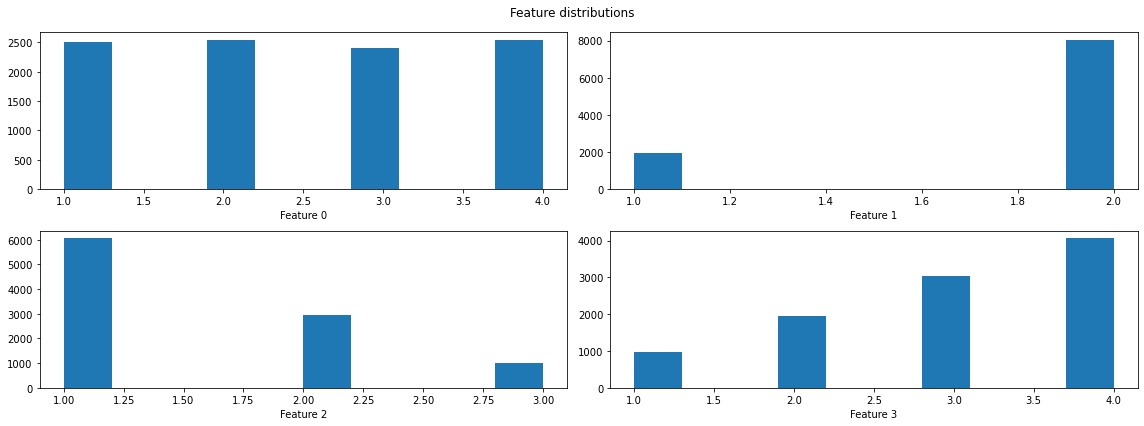

In [10]:
fig, axs = plt.subplots(2, math.ceil(NUM_FEATURES/2), figsize=(16,6))
for i, ax in zip(range(NUM_FEATURES), axs.flatten()):
    ax.hist(contexts[:, i])
    ax.set_xlabel(f"Feature {i}")
fig.suptitle('Feature distributions')
plt.tight_layout()

## Creating cost vectors

In [11]:
# Mean of gaussian distribution random in interval [0, 0.1] 
interval_means = [np.random.uniform(0, 0.05, size=(NUM_FEATURES,)) for i in range(5)]

In [12]:
# Fixed std
interval_stds = [[0.0005]*NUM_FEATURES]*5

In [13]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=NUM_FEATURES,
        change_points=[3000, 4500, 5500, 8000],
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

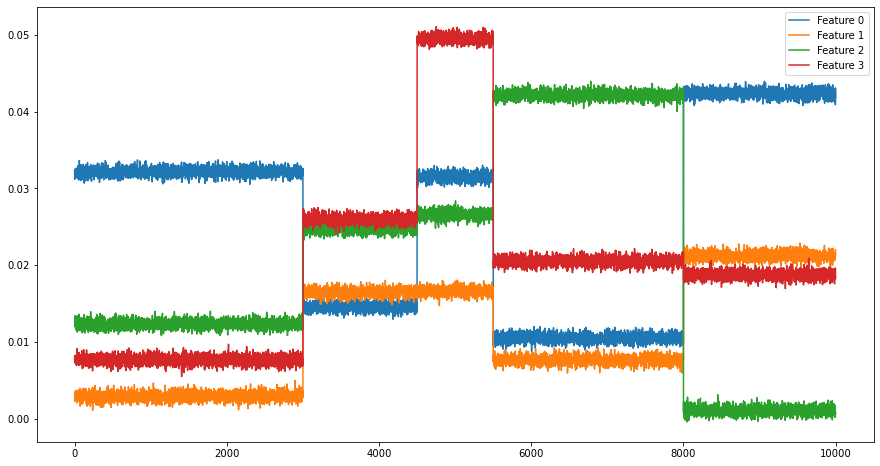

In [14]:
plot_costs(get_costs(), 10000)

In [15]:
costs_obj = get_costs()

In [16]:
costs_vector = []
for t in range(TIME_POINTS):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [17]:
costs_vector.shape

(10000, 4)

## Creating rewards

In [18]:
rewards = np.zeros((TIME_POINTS, N_ARMS))

In [19]:
slices = [
    slice(0,2000),
    slice(2000,4000),
    slice(4000,6000),
    slice(6000,8000),
    slice(8000,10000),
]

In [20]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [21]:
np.random.seed(42)

In [22]:
# Separate all timesteps into slices. For each slice and for each arm generate ground truth bandit parameter theta.
# Take dot product of theta with expected context and put this through sigmoid to get p for Bernoulli distribution. 
# Sample reward for each slice and arm from this distribution.

# Here reward is stationary for given slice, arm.
# So piece-wise stationary for a given arm, not depending on context.

for i, interval_slice in enumerate(slices):
    context_slice = contexts[interval_slice, :]
    slice_len = context_slice.shape[0]
    print(f"Slice {i}:")
    for arm in range(N_ARMS):
        # Ground truth bandit parameter for given arm. These parameters are piecewise-constant.
        random_vec = np.random.normal(size=NUM_FEATURES)
        theta = random_vec / np.linalg.norm(random_vec)

        expected_context = np.mean(context_slice, axis=0)
        z = expected_context @ theta
        
        # Parameter of bernoulli distribution of rewards for this slice and arm.
        p = sigmoid(z)
        
        # Sample rewards from the obtained distribution.
        slice_rewards = np.random.binomial(n=1, p=p, size=(slice_len,))
        rewards[interval_slice, arm] = slice_rewards
        
        # Check that thetas found by linear regression give estimation of expected reward close to
        # true expected reward. 
        
        # thetas found by solving linear regression problem
        linreg_theta,res,rank,s = np.linalg.lstsq(a=context_slice, b=slice_rewards)
        
        estimated_reward = np.mean(context_slice @ linreg_theta, axis=0)
        
        print(
            f"  Arm {arm}: p={np.mean(p):.2f}, mean reward={np.mean(slice_rewards):.2f}",
            f"  reward estimated by linear regression {estimated_reward:.2f}", 
        )


    

Slice 0:
  Arm 0: p=0.98, mean reward=0.98   reward estimated by linear regression 0.95
  Arm 1: p=0.76, mean reward=0.76   reward estimated by linear regression 0.75
  Arm 2: p=0.03, mean reward=0.03   reward estimated by linear regression 0.03
  Arm 3: p=0.80, mean reward=0.80   reward estimated by linear regression 0.78
  Arm 4: p=0.91, mean reward=0.92   reward estimated by linear regression 0.90
Slice 1:
  Arm 0: p=0.91, mean reward=0.91   reward estimated by linear regression 0.89
  Arm 1: p=0.48, mean reward=0.47   reward estimated by linear regression 0.46
  Arm 2: p=0.36, mean reward=0.36   reward estimated by linear regression 0.35
  Arm 3: p=0.20, mean reward=0.19   reward estimated by linear regression 0.19
  Arm 4: p=0.96, mean reward=0.95   reward estimated by linear regression 0.93
Slice 2:
  Arm 0: p=0.56, mean reward=0.54   reward estimated by linear regression 0.53
  Arm 1: p=0.03, mean reward=0.04   reward estimated by linear regression 0.04
  Arm 2: p=0.04, mean rew

/var/folders/_g/d2bwsxss6v9_1830lrh6wyth0000gn/T/ipykernel_7417/3873145888.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  linreg_theta,res,rank,s = np.linalg.lstsq(a=context_slice, b=slice_rewards)


In [23]:
rewards.shape

(10000, 5)

In [24]:
costs_vector.shape

(10000, 4)

## Testing algorithms on synthetic data

In [25]:
NUM_OF_TRIALS = 10000

In [26]:
p_random = algorithms.RandomPolicy()
gain_random = evaluation.evaluate_on_synthetic_data(
    p_random,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)

Random policy
Total gain: 5311.0
	Total reward: 5311.0
	Total cost: 0
Execution time: 0.1s


In [27]:
egreedy = algorithms.EpsilonGreedy(epsilon=0.01, n_arms=rewards.shape[1])

gain_egreedy = evaluation.evaluate_on_synthetic_data(
    egreedy,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)

E-greedy(epsilon=0.01)
Total gain: 9414.0
	Total reward: 9414.0
	Total cost: 0
Execution time: 0.1s


In [28]:
ucb_alg = algorithms.UCB1(
        n_trials=NUM_OF_TRIALS,
        n_arms=rewards.shape[1],
        alpha=0.4,
    )

gain_ucb = evaluation.evaluate_on_synthetic_data(
    ucb_alg,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)

UCB1 (α=0.4)
Total gain: 9423.0
	Total reward: 9423.0
	Total cost: 0
Execution time: 0.1s


In [29]:
linucb = algorithms.LinUCB(
    context_dimension=contexts.shape[1],
    n_arms=rewards.shape[1],
    alpha=0.4,
)
gain_linucb = evaluation.evaluate_on_synthetic_data(
    linucb,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)

LinUCB (alpha=0.4)
Total gain: 7413.851784868798
	Total reward: 8195.0
	Total cost: 781.1482151311807
Execution time: 0.3s


In [30]:
ps_linucb = algorithms.PSLinUCB(
    context_dimension=contexts.shape[1],
    n_arms=rewards.shape[1],
    alpha=0.3,
    omega=200,
    delta=0.1,
)


gain_pslinucb = evaluation.evaluate_on_synthetic_data(
    ps_linucb,
    contexts,
    rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)
change_points = ps_linucb.change_points

PSLinUCB (alpha=0.3, omega=200, delta=0.1)
Total gain: 8033.851784868796
	Total reward: 8815.0
	Total cost: 781.1482151311807
Execution time: 1.2s


In [31]:
np.random.seed(42)

In [32]:
s = time.time()
p_simoos = algorithms.SimOOSAlgorithm(
    all_contexts=contexts, 
    number_of_actions=rewards.shape[1],
    max_no_red_context=contexts.shape[1],
    beta_SimOOS=1,
    delta_SimOOS=0.1,
)
print(f"Took {time.time() - s} seconds")

Took 0.02271723747253418 seconds


In [33]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    s = time.time()
    gain_simoos = evaluation.evaluate_on_synthetic_data(
        p_simoos,
        contexts[:NUM_OF_TRIALS],
        rewards[:NUM_OF_TRIALS],
        costs_vector[:NUM_OF_TRIALS],
        stop_after=NUM_OF_TRIALS,
    )
    print(f"Took {time.time() - s} seconds")


KeyboardInterrupt: 

In [34]:
np.random.seed(42)

In [35]:
s = time.time()
p_alg1 = algorithms.Algorithm1(
    all_contexts=contexts, 
    number_of_actions=rewards.shape[1],
    max_no_red_context=contexts.shape[1],
    beta_SimOOS=1,
    delta_SimOOS=0.1,
    window_length=100,
)
print(f"Took {time.time() - s} seconds")

Took 0.04080820083618164 seconds


In [36]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    s = time.time()
    gain_alg1 = evaluation.evaluate_on_synthetic_data(
        p_alg1,
        contexts[:NUM_OF_TRIALS],
        rewards[:NUM_OF_TRIALS],
        costs_vector[:NUM_OF_TRIALS],
        stop_after=NUM_OF_TRIALS,
    )
    print(f"Took {time.time() - s} seconds")


Round 500, time 2022-03-12 11:54:48.479574
Round 1000, time 2022-03-12 11:55:18.974425
Round 1500, time 2022-03-12 11:55:49.304359
Round 2000, time 2022-03-12 11:56:19.954908
Round 2500, time 2022-03-12 11:56:50.482729
Round 3000, time 2022-03-12 11:57:21.791526
Round 3500, time 2022-03-12 11:57:53.644675
Round 4000, time 2022-03-12 11:58:25.456901
Round 4500, time 2022-03-12 11:58:56.176373
Round 5000, time 2022-03-12 11:59:26.933197
Round 5500, time 2022-03-12 11:59:59.206451
Round 6000, time 2022-03-12 12:00:31.806321
Round 6500, time 2022-03-12 12:01:03.290470
Round 7000, time 2022-03-12 12:01:35.633637
Round 7500, time 2022-03-12 12:02:07.807822
Round 8000, time 2022-03-12 12:02:39.109680
Round 8500, time 2022-03-12 12:03:11.649814
Round 9000, time 2022-03-12 12:03:43.810435
Round 9500, time 2022-03-12 12:04:16.744894
Algorithm1 (beta=1, delta=0.1, w=100)
Total gain: 7486.737297318084
	Total reward: 7799.0
	Total cost: 312.26270268189967
Execution time: 10.5m
Took 629.245573043823

In [39]:
s = time.time()
p_alg1 = algorithms.Algorithm1(
    all_contexts=contexts, 
    number_of_actions=rewards.shape[1],
    max_no_red_context=contexts.shape[1],
    beta_SimOOS=1,
    delta_SimOOS=0.1,
    window_length=500,
)
print(f"Took {time.time() - s} seconds")

Took 0.02438974380493164 seconds


In [40]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    s = time.time()
    gain_alg1 = evaluation.evaluate_on_synthetic_data(
        p_alg1,
        contexts[:NUM_OF_TRIALS],
        rewards[:NUM_OF_TRIALS],
        costs_vector[:NUM_OF_TRIALS],
        stop_after=NUM_OF_TRIALS,
    )
    print(f"Took {time.time() - s} seconds")


Round 500, time 2022-03-12 12:08:07.153522
Round 1000, time 2022-03-12 12:09:00.388018
Round 1500, time 2022-03-12 12:09:52.257471
Round 2000, time 2022-03-12 12:10:45.049233
Round 2500, time 2022-03-12 12:11:36.290715
Round 3000, time 2022-03-12 12:12:28.728046
Round 3500, time 2022-03-12 12:13:22.160374
Round 4000, time 2022-03-12 12:14:16.778138
Round 4500, time 2022-03-12 12:15:12.455090
Round 5000, time 2022-03-12 12:16:06.335619
Round 5500, time 2022-03-12 12:16:57.874457
Round 6000, time 2022-03-12 12:17:52.270656
Round 6500, time 2022-03-12 12:18:44.522492
Round 7000, time 2022-03-12 12:19:39.406843
Round 7500, time 2022-03-12 12:20:31.967122
Round 8000, time 2022-03-12 12:21:23.949160
Round 8500, time 2022-03-12 12:22:19.009624
Round 9000, time 2022-03-12 12:23:15.802622
Round 9500, time 2022-03-12 12:24:09.214630
Algorithm1 (beta=1, delta=0.1, w=500)
Total gain: 7516.767748297035
	Total reward: 7991.0
	Total cost: 474.23225170294654
Execution time: 17.5m
Took 1051.50956320762

In [41]:
s = time.time()
p_alg1 = algorithms.Algorithm1(
    all_contexts=contexts, 
    number_of_actions=rewards.shape[1],
    max_no_red_context=contexts.shape[1],
    beta_SimOOS=1,
    delta_SimOOS=0.1,
    window_length=250,
)
print(f"Took {time.time() - s} seconds")

Took 0.030312061309814453 seconds


In [ ]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    s = time.time()
    gain_alg1 = evaluation.evaluate_on_synthetic_data(
        p_alg1,
        contexts[:NUM_OF_TRIALS],
        rewards[:NUM_OF_TRIALS],
        costs_vector[:NUM_OF_TRIALS],
        stop_after=NUM_OF_TRIALS,
    )
    print(f"Took {time.time() - s} seconds")


Round 500, time 2022-03-12 12:25:34.593653
Round 1000, time 2022-03-12 12:26:12.721156
Round 1500, time 2022-03-12 12:26:50.634571
Round 2000, time 2022-03-12 12:27:28.866387
Round 2500, time 2022-03-12 12:28:07.255619
Round 3000, time 2022-03-12 12:28:46.009287
Round 3500, time 2022-03-12 12:29:25.511055


In [ ]:
p_alg1.rounds

In [ ]:
p_simoos.rounds

In [ ]:
def plot_gains(gain_dict, change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(16, 8));
        
    max_vline=0
    
    for label, gain in gain_dict.items():
        ax.plot(gain, label=label)
        max_vline=max(max_vline, max(gain))
    ax.set_xlabel('Trial')
    ax.set_ylabel('Cumulative gain')
    ax.set_title('Evaluation on synthetic data')
    
    ax.vlines(change_points, 0, max_vline, label='change points', color='pink')

    plt.legend();
    plt.show();

In [ ]:
plot_gains({
    'Random': gain_random,
#     'E-greedy': gain_egreedy,
#     'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'PS-LinUCB': gain_pslinucb,
#     'SimOOS': gain_simoos,
    'Algorithm1': gain_alg1,
},
)
